# Challenge Description

We have data about users who hit our site: whether they converted or not as well as some of their characteristics such as their country, the marketing channel, their age, whether they are repeat users and the number of pages visited during that session (as a proxy for site activity/time spent on site).

### There are two goals for this challenge:

1. Predict conversion rate
2. Come up with recomendations to help product and marketing team increase recomendations

### Import standard packages

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

### Load the dataset

In [46]:
# Reading in the data frame from a csv 
df = pd.read_csv('~/Data/conversion_data.csv')
df.head(5)

,country,age,new_user,source,total_pages_visited,converted
0,UK,25,1,Ads,1,0
1,US,23,1,Seo,5,0
2,US,28,1,Seo,4,0
3,China,39,1,Seo,5,0
4,US,30,1,Seo,6,0


### Summary of variables:
* country = country the user is from
* age = age
* new_user = 1 if first time user, 0 if a repeate user
* source = how the user came to our site
* total_pages_visited = number of pages visited during that session
* converted = did the user by during the session (0 = no; 1 = yes)

# Outline of Analysis Approach:

1. Exploratory Data Analysis/ Data Cleaning
2. Pre-processing and Feature Engineering
3. Modelbuilding and Evaluation

### Basic information about the data

In [6]:
# What's the shape of the data frame?
df.shape

(316200, 6)

There are 316,200 observations of 6 variables

In [8]:
# Getting variable data types
df.dtypes

country                object
age                     int64
new_user                int64
source                 object
total_pages_visited     int64
converted               int64
dtype: object

In [10]:
# Basic description of the data using describe()
df.describe()

,age,new_user,total_pages_visited,converted
count,316200.000000,316200.000000,316200.000000,316200.000000
mean,30.569858,0.685465,4.872966,0.032258
std,8.271802,0.464331,3.341104,0.176685
min,17.000000,0.000000,1.000000,0.000000
25%,24.000000,0.000000,2.000000,0.000000
50%,30.000000,1.000000,4.000000,0.000000
75%,36.000000,1.000000,7.000000,0.000000
max,123.000000,1.000000,29.000000,1.000000


### Observations:

1. Mean age = 30.57 with std = 8.27 years. Probably some erroneous outliers because it says the max age is 123 yrs old

2. New_users and converted don't really make sense to consider here.

3. Total_pages_visited could be informative... mean = 4.87, std = 3.34 and max = 29

#### Let's look at unique ages and see if outliers are there that need to be removed

In [45]:
# What are all of the unique age values in the data
df['age'].unique()

array([ 25,  23,  28,  39,  30,  31,  27,  29,  38,  43,  24,  36,  37,
        33,  20,  35,  17,  50,  22,  18,  34,  19,  42,  32,  21,  48,
        40,  41,  26,  45,  44,  49,  46,  56,  52,  54,  51,  47,  53,
        60,  57,  55,  59,  61,  58,  62,  65,  63,  66,  67,  64,  68,
        69, 123,  70,  73,  77,  72,  79, 111])

In [53]:
# how frequently are these extrmeley high ages occuring?
age_counts = df.groupby('age').count()
age_counts.iloc[-6:,0]

age
72     1
73     1
77     1
79     1
111    1
123    1
Name: country, dtype: int64

These ages in the 100's are only occuring once each, for the sake of this analysis I'll assume that everything above 80 can be removed.

## Let's have a look at the distributions for Age and Total_pages_visited

### Distribution of Ages in data set

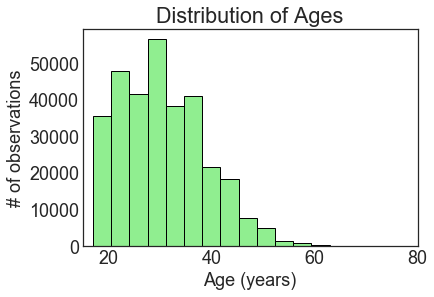

In [34]:
# Plotting a histogram to see distribution of ages in dataset
sns.set_style("white")
plt.hist(df['age'], 30, facecolor='lightgreen', edgecolor='black')
plt.xlabel('Age (years)')
plt.ylabel('# of observations')
plt.title('Distribution of Ages')
plt.xlim(15,80)
plt.rcParams.update({'font.size': 18})

### Distribution of total_pages_visited in the dataset

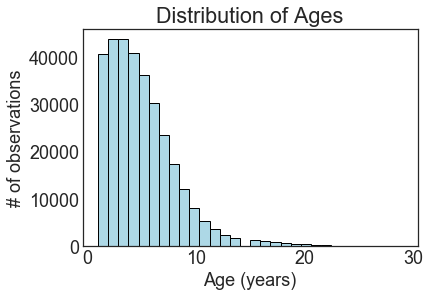

In [54]:
# Plotting a histogram to see distribution of total_pages_visited in dataset
sns.set_style("white")
plt.hist(df['total_pages_visited'], 30, facecolor='lightblue', edgecolor='black')
plt.xlabel('Age (years)')
plt.ylabel('# of observations')
plt.title('Distribution of Ages')
plt.rcParams.update({'font.size': 18})

# What's the empirical conversion rate?

The first place I want to start

In [17]:
df.shape

(316200, 6)

In [18]:
df['converted'].sum()

10200

### Overall empirical conversion rate

In [19]:
(10200/316200) * 100

3.225806451612903

So the overall conversion rate in this dataset is  ~ 3.23 percent.

## Let's start to explore some of the variables and see whether they have an impact on the conversion rate

In [55]:
# Just getting the names of the columns
df.columns

Index(['country', 'age', 'new_user', 'source', 'total_pages_visited',
       'converted'],
      dtype='object')

## Looking at conversion rates: Country x Source

In [56]:
# Creating pivot tables for the # of conversions and total obsrvations for see
# if there is some relationship between counrty and source on conversion
con_ads_sum = df.pivot_table(index='country', columns = 'source', 
                    aggfunc={'converted':sum})

con_ads_len = df.pivot_table(index='country', columns = 'source', 
                    aggfunc={'converted':len})


In [57]:
# Number of converted cases broken down by country and souce
con_ads_sum

converted             
source        Ads Direct   Seo
country                       
China          32     24    46
Germany       251    153   412
UK            752    515  1283
US           2025   1348  3359

In [59]:
# Total number of observations from each country and source
con_ads_len

converted              
source        Ads Direct    Seo
country                        
China       21561  17463  37578
Germany      3760   2864   6432
UK          13518  11131  23801
US          49901  40962  87229

### Calculating the Actual Conversion Rates

In [60]:
converted_rate = (con_ads_sum / con_ads_len) * 100
converted_rate

converted                    
source        Ads    Direct       Seo
country                              
China    0.148416  0.137433  0.122412
Germany  6.675532  5.342179  6.405473
UK       5.562953  4.626718  5.390530
US       4.058035  3.290855  3.850784

Quick glance: China seems to be much lower than others

### Visualizing conversion rates for country x source

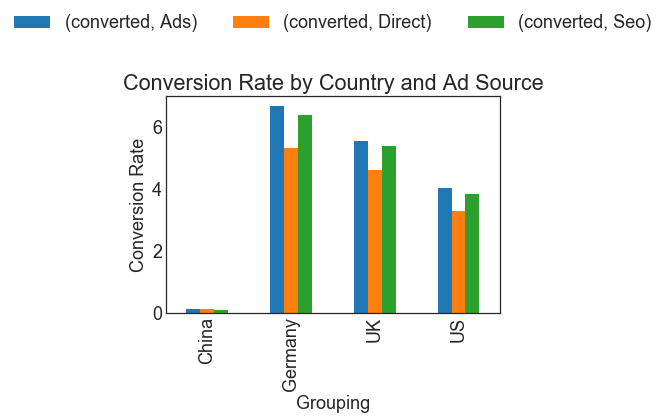

In [62]:
# barplot of conversion rates for country x source
converted_rate.plot(kind='bar')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.45),
          ncol=3, fancybox=True)
plt.ylabel('Conversion Rate')
plt.xlabel('Grouping')
plt.title('Conversion Rate by Country and Ad Source')
plt.rcParams.update({'font.size': 15})

## Let's look more into how many users we have from different countries

In [63]:
country_counts = df.groupby('country').count()
country_counts.iloc[:,1]

country
China       76602
Germany     13056
UK          48450
US         178092
Name: new_user, dtype: int64

## More than 1/2 of users from Germany; US ~ to China

([<matplotlib.patches.Wedge at 0x117e45128>,
  <matplotlib.text.Text at 0x117e77da0>])

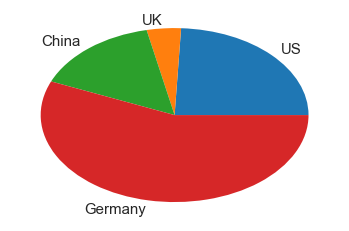

In [64]:
lab = ['US','UK','China','Germany']
plt.pie(country_counts.iloc[:,1],labels = lab)

### Discovery # 1 and 2:

#### Number 1: China's conversion rates are much lower tha other countries

#### Number 2: Germany comprises > 1/2 of users; US & China ~ 20-25%

# Further exploring conversion rates and other variables

## How does age impact conversion rates and country/ source

In [65]:
# creating age bins
age = pd.cut(df['age'], [0, 20, 30, 40, 50])

In [73]:
# Getting the number of conversion and total number of obsrvations
conversion_sum_age = df.pivot_table(index= age,
                    aggfunc={'converted':sum})

conversion_len_age = df.pivot_table(index= age, 
                    aggfunc={'converted':len})

In [74]:
converted_rate_age_only = (conversion_sum_age / conversion_len_age) * 100
converted_rate_age_only

,converted
age,
"(0, 20]",6.272492
"(20, 30]",4.008830
"(30, 40]",2.078157
"(40, 50]",1.105926


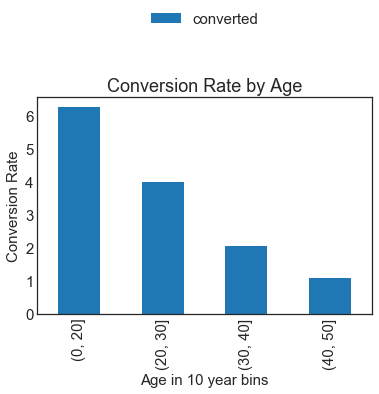

In [76]:
converted_rate_age_only.plot(kind='bar')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.45),
          ncol=3, fancybox=True)
plt.ylabel('Conversion Rate')
plt.xlabel('Age in 10 year bins')
plt.title('Conversion Rate by Age')

Age seems like it matters... let's see how it impacts other variable

## Converstion Rates: Country x Source x Age

In [67]:
# Example of how the new pivot table is going to look - (# of conversions)
df.pivot_table(index='country', columns = ['source', age], 
                    aggfunc={'converted':sum})

converted                                                       \
source        Ads                             Direct                     
age       (0, 20] (20, 30] (30, 40] (40, 50] (0, 20] (20, 30] (30, 40]   
country                                                                  
China           6       22        4        0       6       14        1   
Germany        57      124       62        8      37       80       32   
UK            171      389      165       26     120      272      106   
US            435     1052      447       85     263      702      327   

                                                     
source               Seo                             
age     (40, 50] (0, 20] (20, 30] (30, 40] (40, 50]  
country                                              
China          3       9       24       13        0  
Germany        4      97      205       92       17  
UK            17     281      672      273       53  
US            54     749     1747      728      124

In [69]:
# Getting the number of conversion and total number of obsrvations
con_sum_age = df.pivot_table(index='country', columns = ['source', age], 
                    aggfunc={'converted':sum})

con_len_age = df.pivot_table(index='country', columns = ['source', age], 
                    aggfunc={'converted':len})

### Calulating the Actual Conversion Rates

In [70]:
converted_rate_age = (con_sum_age / con_len_age) * 100
converted_rate_age

converted                                                     \
source         Ads                                   Direct             
age        (0, 20]  (20, 30]  (30, 40]  (40, 50]    (0, 20]  (20, 30]   
country                                                                 
China     0.255646  0.244363  0.053605  0.000000   0.304414  0.192097   
Germany  12.638581  7.784055  4.912837  1.946472  11.671924  6.482982   
UK       11.430481  6.746445  3.586957  1.763908   9.600000  5.771271   
US        7.693668  5.032770  2.618016  1.530704   5.784033  4.097117   

                                                                      
source                             Seo                                
age      (30, 40]  (40, 50]    (0, 20]  (20, 30]  (30, 40]  (40, 50]  
country                                                               
China    0.016647  0.155844   0.216867  0.153708  0.100947  0.000000  
Germany  3.343783  1.261830  12.967914  7.730015  4.144144  2.344828  
UK       2.759698  1.457976   9.978693  6.768053  3.409943  1.945668  
US       2.326409  1.182654   7.626515  4.792341  2.434294  1.276640

## Barplot to visualize conversion rate by groups

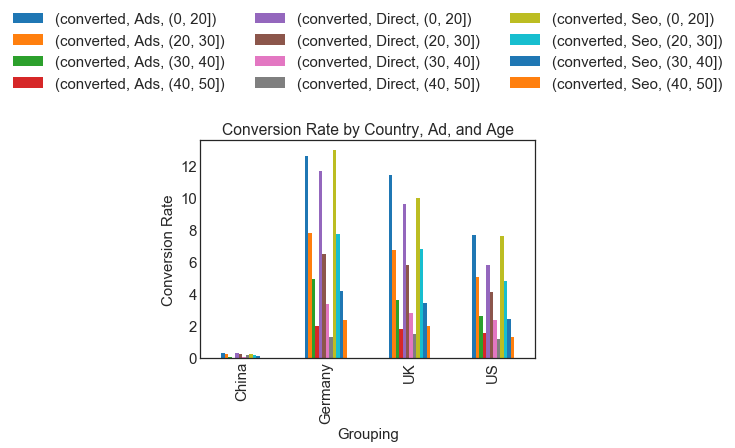

In [79]:
converted_rate_age.plot(kind='bar')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.65),
          ncol=3, fancybox=True)
plt.rcParams.update({'font.size': 13})
plt.ylabel('Conversion Rate')
plt.xlabel('Grouping')
plt.title('Conversion Rate by Country, Ad, and Age')


For Germany, US, UK, Young people convert at highest rates regardless of source

## Country x Age only

In [80]:
conversion_cont_age_sum = df.pivot_table(index='country', columns = [age], 
                    aggfunc={'converted':sum})

conversion_con_age_len = df.pivot_table(index='country', columns = [age], 
                    aggfunc={'converted':len})

In [81]:
converted_rate_cont_age = (conversion_cont_age_sum / conversion_con_age_len) * 100
converted_rate_cont_age

converted                              
age        (0, 20]  (20, 30]  (30, 40]  (40, 50]
country                                         
China     0.247992  0.188058  0.068319  0.034459
Germany  12.598945  7.464866  4.190133  1.995871
UK       10.284070  6.531752  3.307594  1.789709
US        7.227050  4.699897  2.460843  1.326140

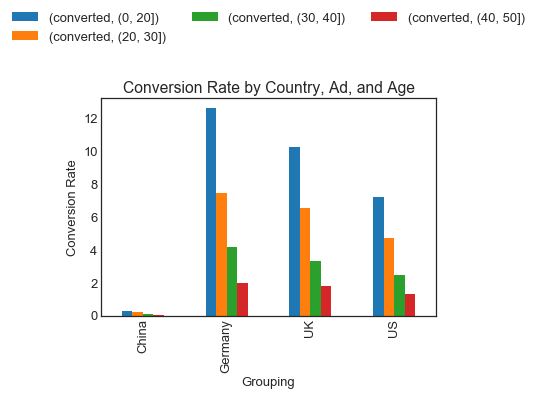

In [82]:
converted_rate_cont_age.plot(kind='bar')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.45),
          ncol=3, fancybox=True)
plt.ylabel('Conversion Rate')
plt.xlabel('Grouping')
plt.title('Conversion Rate by Country, Ad, and Age')

## Getting counts per source

In [83]:
source_counts = df.groupby('source').count()
source_counts.iloc[:,1]

source
Ads        88740
Direct     72420
Seo       155040
Name: age, dtype: int64

In [84]:
labs = ['Ads','Direct','Seo']

## Half of users come in through SEO

([<matplotlib.patches.Wedge at 0x11ccc56d8>,
  <matplotlib.text.Text at 0x11ccd57b8>])

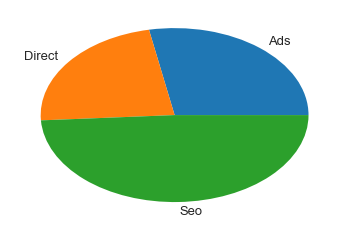

In [85]:
plt.pie(source_counts.iloc[:,1],labels = labs)

In [86]:
conversion_source_sum = df.pivot_table(index='source', 
                    aggfunc={'converted':sum})

conversion_source_len = df.pivot_table(index='source', 
                    aggfunc={'converted':len})

In [87]:
converted_rate_source = (conversion_source_sum / conversion_source_len) * 100
converted_rate_source

,converted
source,
Ads,3.448276
Direct,2.816901
Seo,3.289474


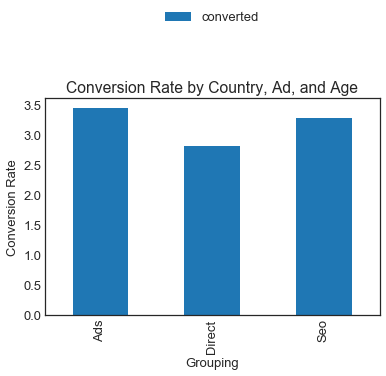

In [88]:
converted_rate_source.plot(kind='bar')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.45),
          ncol=3, fancybox=True)
plt.ylabel('Conversion Rate')
plt.xlabel('Grouping')
plt.title('Conversion Rate by Country, Ad, and Age')

despite half of all users coming in through search engine optimization, there are equal conversion rates among all source categories... might be wasting money here

# 3) Modelling Stage

## Creating targey verctor

In [89]:
y = df.converted

# Convert categorical variables to dummy variables 

In [90]:
# Changing categorical variabes into dummy variables
df1 = pd.get_dummies(df)
df1.head(6)

,age,new_user,total_pages_visited,converted,country_China,country_Germany,country_UK,country_US,source_Ads,source_Direct,source_Seo
0,25,1,1,0,0,0,1,0,1,0,0
1,23,1,5,0,0,0,0,1,0,0,1
2,28,1,4,0,0,0,0,1,0,0,1
3,39,1,5,0,1,0,0,0,0,0,1
4,30,1,6,0,0,0,0,1,0,0,1
5,31,0,1,0,0,0,0,1,0,0,1


# Drop converted from the feature matrix

In [91]:
# Creating feature matrix X by dropping the target column 
X = df1.drop('converted',axis=1)
X.head(4)

,age,new_user,total_pages_visited,country_China,country_Germany,country_UK,country_US,source_Ads,source_Direct,source_Seo
0,25,1,1,0,0,1,0,1,0,0
1,23,1,5,0,0,0,1,0,0,1
2,28,1,4,0,0,0,1,0,0,1
3,39,1,5,1,0,0,0,0,0,1


# Using a decison tree classifier and random forest to model conversion

In [92]:
# Importing the train_test_split module from sklearn
from sklearn.model_selection import train_test_split

In [93]:
# split the dataset into a training and a test set
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = .7, random_state=0)

### Defining and fitting the model

In [94]:
# Importing the decision tree module
from sklearn.tree import DecisionTreeClassifier

# Defining the decision tree model
tree = DecisionTreeClassifier(random_state=0)

# Fitting the decision tree to the training data
tree.fit(X_train, y_train)

# Printing the training and test set score:
print("Accuracy on training set: {:.3f}".format(tree.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(tree.score(X_test, y_test)))

Accuracy on training set: 0.989
Accuracy on test set: 0.984


### Does max depth allowed have an impact?

In [98]:
tree = DecisionTreeClassifier(max_depth = 3, random_state=0)
tree.fit(X_train, y_train)

print("Accuracy on training set: {:.3f}".format(tree.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(tree.score(X_test, y_test)))

Accuracy on training set: 0.985
Accuracy on test set: 0.984


In [99]:
# Could print the feature importance for each variable with below code
#print("Feature importances:\n{}".format(tree.feature_importances_))

In [121]:
m = tree.feature_importances_
m.sort()
m

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.01594601,  0.04930744,  0.93474655])

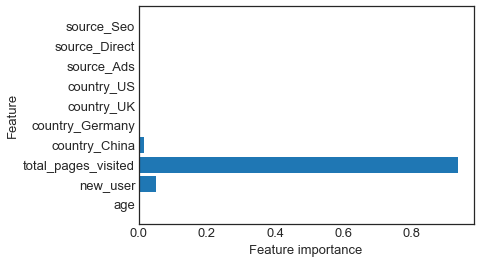

In [127]:
# Defining a function to plot the feature importance
def plot_feature_importances(model):
    n_features = X.shape[1]
    plt.barh(range(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), X.columns)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
    plt.ylim(-1, n_features)

plot_feature_importances(tree)

## Can a random forest classifier do better?

In [128]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(n_estimators=3, random_state=2)
forest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=3, n_jobs=1, oob_score=False, random_state=2,
            verbose=0, warm_start=False)

In [129]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=0)
forest = RandomForestClassifier(n_estimators=3, random_state=0)
forest.fit(X_train, y_train)

print("Accuracy on training set: {:.3f}".format(forest.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(forest.score(X_test, y_test)))

Accuracy on training set: 0.988
Accuracy on test set: 0.984


## Feature importance from random forest

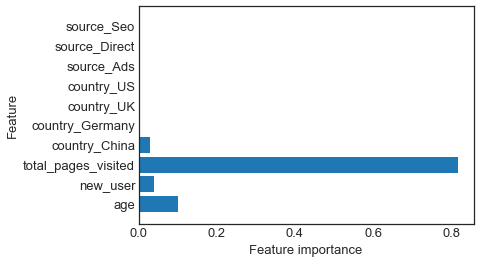

In [130]:
plot_feature_importances(forest)

In [131]:
y_score = y_score = forest.predict(X_test)

In [132]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_score)
con_mat = confusion_matrix(y_test, y_score)


In [133]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


In [134]:
import itertools

## COnfusion Matrix without normalization

Confusion matrix, without normalization
[[76045   408]
 [  872  1725]]


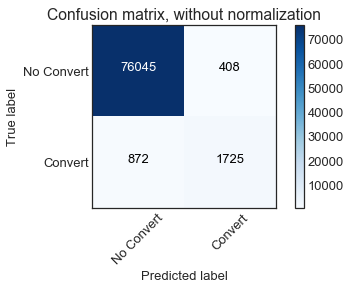

In [135]:
# Plot non-normalized confusion matrix
class_names = ['No Convert','Convert']
plt.figure()
plot_confusion_matrix(con_mat,classes=class_names,
                     title='Confusion matrix, without normalization')


## Confusion Matrix with Normalization

Normalized confusion matrix
[[ 0.99466339  0.00533661]
 [ 0.33577204  0.66422796]]


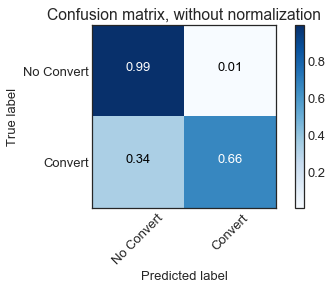

In [136]:
plt.figure()
plot_confusion_matrix(con_mat,classes=class_names,
                      normalize = True,
                     title='Confusion matrix, without normalization')

## Looking at Precision and Recall Score

In [137]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score


print("Precision:", precision_score(y_test, y_score))
print("Recall:", recall_score(y_test, y_score))

Precision: 0.808720112518
Recall: 0.664227955333


In [138]:
from sklearn.metrics import average_precision_score
average_precision = average_precision_score(y_test, y_score)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

Average precision-recall score: 0.74


## Precision Recall Curve

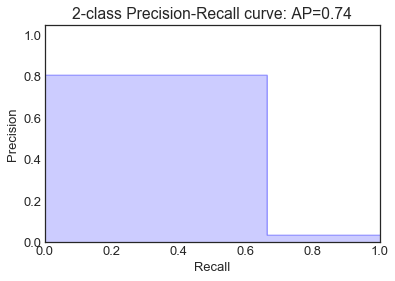

In [139]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

precision, recall, _ = precision_recall_curve(y_test, y_score)

plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))

Not sure about this precision recall curve - looks funny to me, would be worth further exploring why

# Conclusions and Recomendations:

1. Get people to stay on the site longer
2. Find out why China converts so much lower and find ways to increase it's conversions
3. Younger people convert at higher rates so figure out how to target adults

# Future Directions

1. The recall is not great, would be nice to try to get that better
2. Only used train test split... would be good to try sampling methods (i.e. oversampling) because there are far fewer converted cases than non-converted
3. Consider models other than Random Forest